In [2]:
import numpy
print(numpy.__version__)

1.26.4


In [1]:
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """Adds random noise to each image in the supplied array."""
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

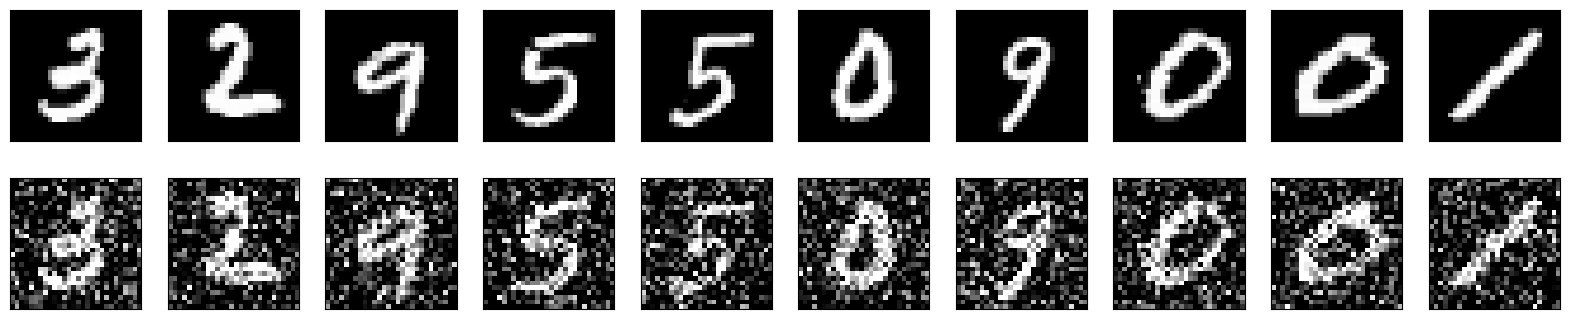

In [5]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

In [6]:
#building the autoencoder
input = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

2025-09-16 13:11:32.783230: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-09-16 13:11:32.783272: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-09-16 13:11:32.783279: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-09-16 13:11:32.783307: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-09-16 13:11:32.783323: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/5


2025-09-16 13:11:35.920006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.2507 - val_loss: 0.0732
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0726 - val_loss: 0.0694
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0694 - val_loss: 0.0680
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0681 - val_loss: 0.0672
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0674 - val_loss: 0.0664


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


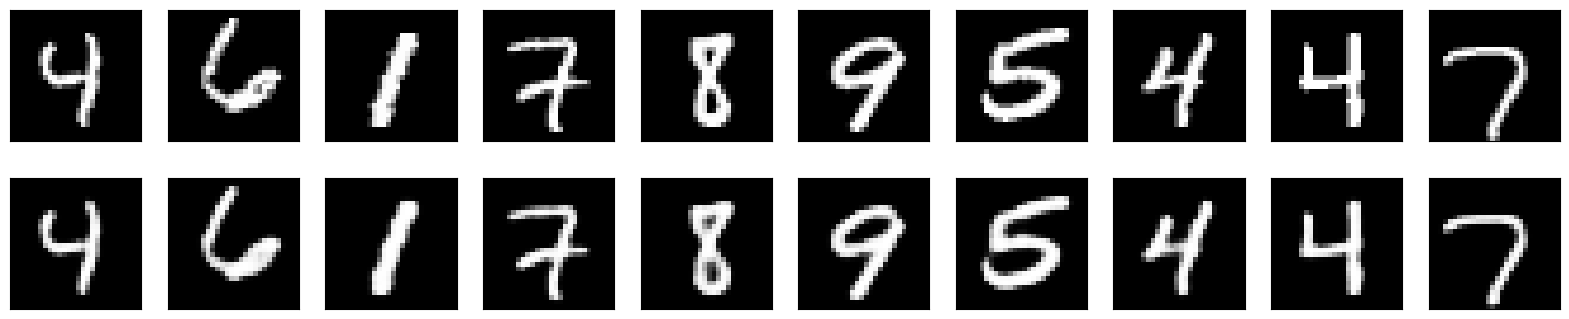

In [8]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [9]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=5,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.1159 - val_loss: 0.0943
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0942 - val_loss: 0.0921
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0923 - val_loss: 0.0907
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 0.0913 - val_loss: 0.0899
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 0.0903 - val_loss: 0.0891


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


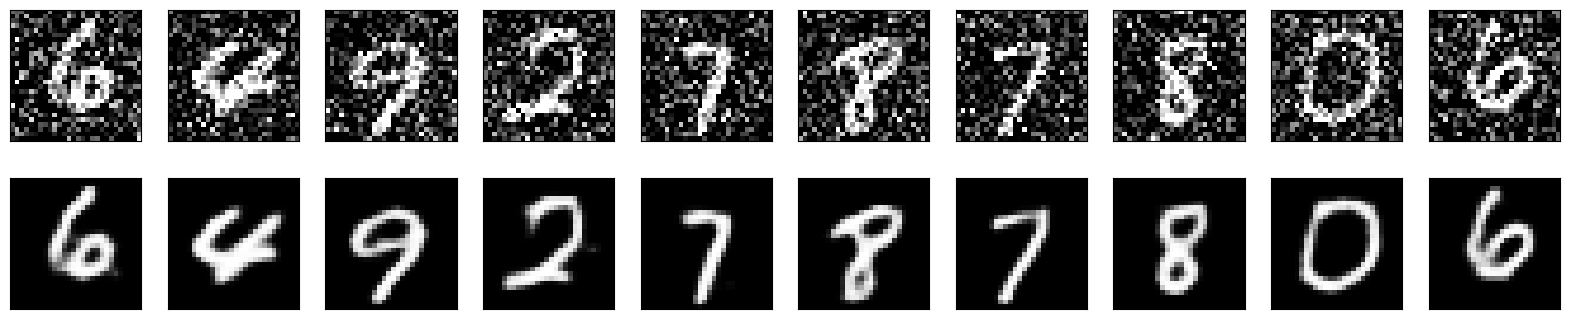

In [10]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)